In [1]:
#_*_coding:utf-8_*_

import numpy as np
import re
import codecs
import itertools
from collections import Counter

import jieba
jieba.initialize()


def clean_str(string):

#     string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
#     string = re.sub(r"\'s", " \'s", string)
#     string = re.sub(r"\'ve", " \'ve", string)
#     string = re.sub(r"n\'t", " n\'t", string)
#     string = re.sub(r"\'re", " \'re", string)
#     string = re.sub(r"\'d", " \'d", string)
#     string = re.sub(r"\'ll", " \'ll", string)
#     string = re.sub(r",", " , ", string)
#     string = re.sub(r"!", " ! ", string)
#     string = re.sub(r"\(", " \( ", string)
#     string = re.sub(r"\)", " \) ", string)
#     string = re.sub(r"\?", " \? ", string)
#     string = re.sub(r"\s{2,}", " ", string)
#     return string.strip().lower()
    string = re.sub(r"！", u"！", string)
    string = re.sub(r"\?", u"？", string)
    string = re.sub(r"\.", u"。", string)
    string = re.sub(r",", u"，", string)
    string = re.sub(ur"[^\u4e00-\u9fa5，。？！]",'',string)
    return string


def load_data_and_labels():
    """
    Loads MR polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    # Load data from files
    positive_examples = list(codecs.open("./data/comment.pos",encoding='utf-8').readlines())
    positive_examples = [s.strip() for s in positive_examples]
    negative_examples = list(codecs.open("./data/comment.neg",encoding='utf-8').readlines())
    negative_examples = [s.strip() for s in negative_examples]
    # Split by words
    x_text = positive_examples + negative_examples
    x_text = [clean_str(sent) for sent in x_text]
    x_text = [jieba.lcut(s) for s in x_text]
    # Generate labels
    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    return [x_text, y]


def pad_sentences(sentences, padding_word="<PAD/>"):
    """
    Pads all sentences to the same length. The length is defined by the longest sentence.
    Returns padded sentences.
    """
    sequence_length = max(len(x) for x in sentences)
    padded_sentences = []
    for i in range(len(sentences)):
        sentence = sentences[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)
    return padded_sentences


def build_vocab(sentences):
    """
    Builds a vocabulary mapping from word to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return [vocabulary, vocabulary_inv]


def build_input_data(sentences, labels, vocabulary):
    """
    Maps sentencs and labels to vectors based on a vocabulary.
    """
    x = np.array([[vocabulary[word] for word in sentence] for sentence in sentences])
    y = np.array(labels)
    return [x, y]

def build_predict_data(sentence,vocabulary,sentence_max_len):

    if len(sentence)<sentence_max_len:
        sentence.extend(['<PAD/>']*(sentence_max_len-len(sentence)))
  
    x=[]
    for word in sentence:
        if word in vocabulary.keys():
            x.append(vocabulary[word])
        else:
            x.append(vocabulary['<PAD/>'])
    x=[x]
    return np.asarray(x)

def load_data():
    """
    Loads and preprocessed data for the MR dataset.
    Returns input vectors, labels, vocabulary, and inverse vocabulary.
    """
    # Load and preprocess data
    sentences, labels = load_data_and_labels()
    sentences_padded = pad_sentences(sentences)
    vocabulary, vocabulary_inv = build_vocab(sentences_padded)
    x, y = build_input_data(sentences_padded, labels, vocabulary)
    return [x, y, vocabulary, vocabulary_inv]


def batch_iter(data, batch_size, num_epochs):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int(len(data) / batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_data = data[shuffle_indices]
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]
            
x, y, vocabulary, vocabulary_inv=load_data()
print type(vocabulary),type(vocabulary_inv)
build_predict_data([u'我','love','china'],vocabulary,10)

# print jieba.lcut(clean_str(u'我喜欢中国人,.?!，。？！'))

Building prefix dict from the default dictionary ...
Loading model from cache c:\users\gld\appdata\local\temp\jieba.cache
Loading model cost 0.394 seconds.
Prefix dict has been built succesfully.


<type 'dict'> <type 'list'>


array([[13,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [2]:
from gensim.models import word2vec
from os.path import join, exists, split
import os
import numpy as np


def train_word2vec(sentence_matrix, vocabulary_inv,
                   num_features=300, min_word_count=1, context=10):
    """
    Trains, saves, loads Word2Vec model
    Returns initial weights for embedding layer.
   
    inputs:
    sentence_matrix # int matrix: num_sentences x max_sentence_len
    vocabulary_inv  # dict {str:int}
    num_features    # Word vector dimensionality                      
    min_word_count  # Minimum word count                        
    context         # Context window size 
    """
    model_dir = 'models'
    model_name = "{:d}features_{:d}minwords_{:d}context".format(num_features, min_word_count, context)
    model_name = join(model_dir, model_name)
    if exists(model_name):
        embedding_model = word2vec.Word2Vec.load(model_name)
        print('Load existing Word2Vec model \'%s\'' % split(model_name)[-1])
    else:
        # Set values for various parameters
        num_workers = 2  # Number of threads to run in parallel
        downsampling = 1e-3  # Downsample setting for frequent words

        # Initialize and train the model
        print('Training Word2Vec model...')
        sentences = [[vocabulary_inv[w] for w in s] for s in sentence_matrix]
        embedding_model = word2vec.Word2Vec(sentences, workers=num_workers,
                                            size=num_features, min_count=min_word_count,
                                            window=context, sample=downsampling)

        # If we don't plan to train the model any further, calling 
        # init_sims will make the model much more memory-efficient.
        embedding_model.init_sims(replace=True)

        # Saving the model for later use. You can load it later using Word2Vec.load()
        if not exists(model_dir):
            os.mkdir(model_dir)
        print('Saving Word2Vec model \'%s\'' % split(model_name)[-1])
        embedding_model.save(model_name)

    # add unknown words
    embedding_weights = [np.array([embedding_model[w] if w in embedding_model
                                   else np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
                                   for w in vocabulary_inv])]
    return embedding_weights


c:\programs\python27\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Load data...
('x_train shape:', (873L, 345L), <type 'numpy.ndarray'>)
('y_train shape:', (873L,), <type 'numpy.ndarray'>)
('x_test shape:', (874L, 345L), <type 'numpy.ndarray'>)
('y_test shape:', (874L,), <type 'numpy.ndarray'>)
('Model type is', 'CNN-rand')


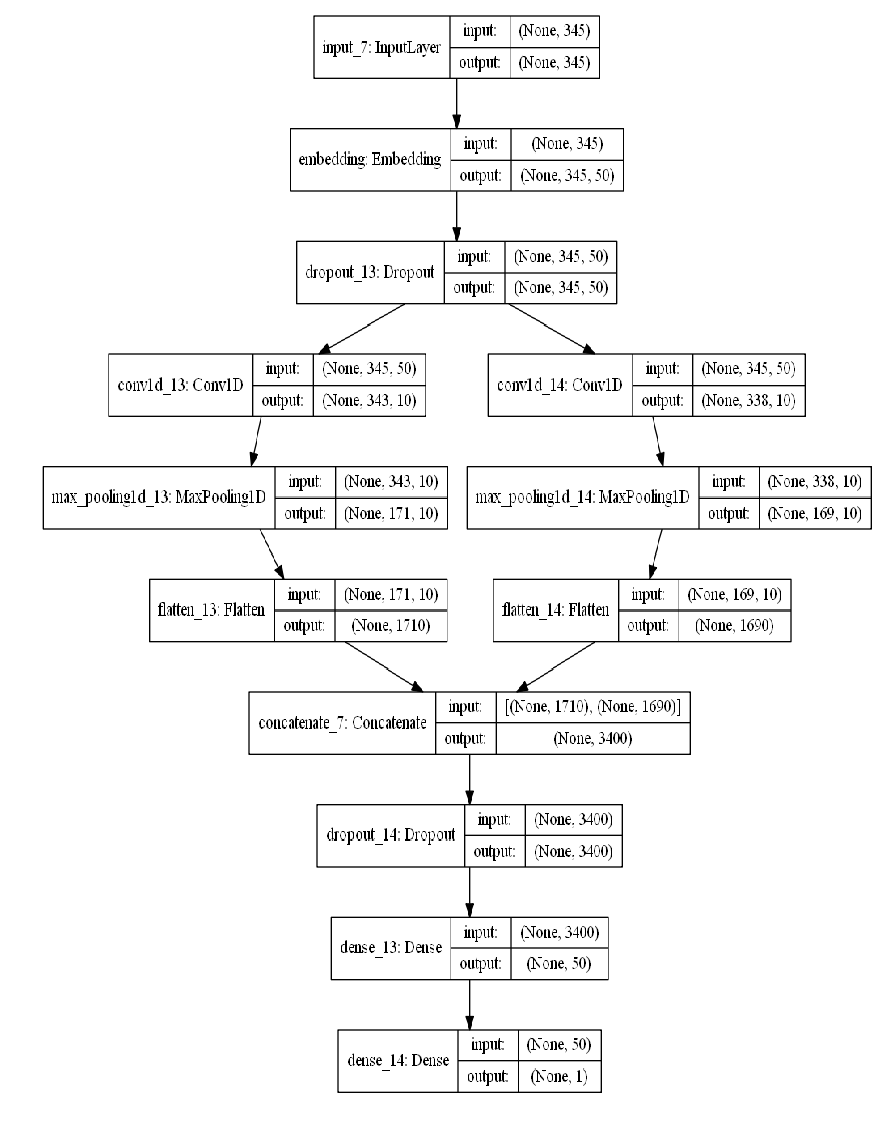

Train on 873 samples, validate on 874 samples
Epoch 1/10
6s - loss: 0.6883 - acc: 0.5510 - val_loss: 0.6824 - val_acc: 0.5709
Epoch 2/10
6s - loss: 0.6840 - acc: 0.5613 - val_loss: 0.6812 - val_acc: 0.5709
Epoch 3/10
6s - loss: 0.6816 - acc: 0.5578 - val_loss: 0.6767 - val_acc: 0.6053
Epoch 4/10
6s - loss: 0.6728 - acc: 0.5911 - val_loss: 0.6598 - val_acc: 0.6224
Epoch 5/10
6s - loss: 0.6299 - acc: 0.6518 - val_loss: 0.6053 - val_acc: 0.7048
Epoch 6/10
6s - loss: 0.5158 - acc: 0.7595 - val_loss: 0.4672 - val_acc: 0.8375
Epoch 7/10
6s - loss: 0.3297 - acc: 0.8889 - val_loss: 0.3552 - val_acc: 0.8581
Epoch 8/10
6s - loss: 0.2103 - acc: 0.9255 - val_loss: 0.3355 - val_acc: 0.8822
Epoch 9/10
6s - loss: 0.1629 - acc: 0.9553 - val_loss: 0.3271 - val_acc: 0.8867
Epoch 10/10
6s - loss: 0.1338 - acc: 0.9496 - val_loss: 0.3369 - val_acc: 0.8867
[[ 0.99405825]]


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate
from keras.datasets import imdb
from keras.preprocessing import sequence
import h5py

np.random.seed(0)

# ---------------------- Parameters section -------------------

model_type = "CNN-rand"  # CNN-rand|CNN-non-static|CNN-static

# Model Hyperparameters
embedding_dim = 50
filter_sizes = (3, 8)
num_filters = 10
dropout_prob = (0.5, 0.8)
hidden_dims = 50

# Training parameters
batch_size = 64
num_epochs = 10

# Prepossessing parameters
sequence_length = 400
max_words = 5000

# Word2Vec parameters (see train_word2vec)
min_word_count = 1
context = 10
#
# ---------------------- Parameters end -----------------------


# Data Preparation
print("Load data...")
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words, start_char=None, oov_char=None,
#                                                       index_from=None)

# x_train = sequence.pad_sequences(x_train, maxlen=sequence_length, padding="post", truncating="post")
# x_test = sequence.pad_sequences(x_test, maxlen=sequence_length, padding="post", truncating="post")
# print("x_train shape:", x_train.shape, type(x_train))
# print("x_test shape:", x_test.shape, type(x_test))
# print("y_train shape:", y_train.shape, type(y_train))
# print("y_test shape:", y_test.shape, type(y_test))

# vocabulary = imdb.get_word_index()
# vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
# vocabulary_inv[0] = "<PAD/>"

# Custom data from dir
x, y, vocabulary, vocabulary_inv = load_data()
y = np.asarray([temp[1] for temp in y])
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=42)
print("x_train shape:", x_train.shape, type(x_train))
print("y_train shape:", y_train.shape, type(y_train))

print("x_test shape:", x_test.shape, type(x_test))
print("y_test shape:", y_test.shape, type(y_test))
sequence_length = len(x_train[0])

# Prepare embedding layer weights and convert inputs for static model
print("Model type is", model_type)
if model_type == "CNN-non-static" or model_type == "CNN-static":
    embedding_weights = train_word2vec(np.vstack((x_train, x_test)), vocabulary_inv, num_features=embedding_dim,
                                       min_word_count=min_word_count, context=context)
if model_type == "CNN-static":
    x_train = embedding_weights[0][x_train]
    x_test = embedding_weights[0][x_test]
elif model_type == "CNN-rand":
    embedding_weights = None
else:
    raise ValueError("Unknown model type")

# Build model
input_shape = (sequence_length,
               embedding_dim) if model_type == "CNN-static" else (sequence_length,)
model_input = Input(shape=input_shape)

# Static model do not have embedding layer
if model_type == "CNN-static":
    z = Dropout(dropout_prob[0])(model_input)
else:
    z = Embedding(len(vocabulary_inv), embedding_dim,
                  input_length=sequence_length, name="embedding")(model_input)
    z = Dropout(dropout_prob[0])(z)

# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

z = Dropout(dropout_prob[1])(z)
z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy",
              optimizer="adam", metrics=["accuracy"])

# Initialize weights with word2vec
if model_type == "CNN-non-static":
    embedding_layer = model.get_layer("embedding")
    embedding_layer.set_weights(embedding_weights)

# Model structure
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plot_model(model, to_file='model.png',show_shapes=True)
image = mpimg.imread("model.png")
plt.figure(figsize=(15,20))
plt.imshow(image,aspect='auto')
plt.axis('off')
plt.show()

# Train the model
model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

pos = u'鞋子不错，穿着舒服，很好用'
neg = u'假的吧，好臭，鞋不行'
print model.predict(build_predict_data(jieba.lcut(pos), vocabulary, sequence_length))

model.save('./cnn.h5')

In [4]:
from keras.models import load_model
model = load_model('./cnn.h5')

pos=u'鞋子挺漂亮了里面还有一个高科技，感觉挺高的上的然后，外表也挺时尚漂亮'
pos=u'鞋子不错，穿着舒服，很好用'
pos=u'鞋子很给力，好评'

neg=u'质量不好，不是正品'
neg=u'鞋子真是不好啊！太廋了！变态硬！'
neg=u'垃圾产品。50元不到的做工卖1百多，去那刷那么多好评 我！'

print model.predict(build_predict_data(jieba.lcut(pos),vocabulary,sequence_length))

[[ 0.78380316]]
